## Final Project Submission

* Student name: Matthew Lipman
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: Amber Yandow
* Blog post URL:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import haversine as hs #geographic distance calculator

## Load and prepare data

In [2]:
df_train = pd.read_csv('data/kc_house_data.csv')

In [3]:
#locations pulled from scientology-seattle.org
church_of_scientology_mission = (47.818100, -122.315430)
church_of_scientology_washington = (47.622380, -122.361020)
church_of_scientology_life_improvement_center = (47.615060, -122.327580)

In [4]:
#function that identifies the distance between a point of interest and house 
def distance_to(point_of_interest):
    distance = df_train[['lat','long']].apply(lambda x: hs.haversine(x.tolist(), point_of_interest), axis=1)
    return distance

In [5]:
#creating new columns of distances from houses to point of interest
df_train['distance_to_scientology_m'] = distance_to(church_of_scientology_mission)
df_train['distance_to_scientology_w'] = distance_to(church_of_scientology_washington)
df_train['distance_to_scientology_l'] = distance_to(church_of_scientology_life_improvement_center)
df_train['closest_distance_to_scientology'] = df_train[['distance_to_scientology_m',
                                                        'distance_to_scientology_w',
                                                        'distance_to_scientology_l']].min(axis=1)

In [6]:
#creating categorical variable 'is_close' to signify houses that are less than 10 km from a church of scientology
df_train['is_close'] = np.where(df_train['closest_distance_to_scientology'] < 10, 1, 0)

In [7]:
#Remove unwanted columns
drop_vars = ['date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated',
             'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
             'bedrooms', 'bathrooms', 'floors', 'sqft_lot', 'waterfront',
             'condition', 'yr_built', 'distance_to_scientology_m', 'distance_to_scientology_w',
             'distance_to_scientology_l', 'id']
df_mvp = df_train.drop(columns=drop_vars)

## Cleaning the data (outliers and transformations)

In [8]:
#standardizing data
price_scaled = StandardScaler().fit_transform(df_mvp['price'][:,np.newaxis]);
low_range = price_scaled[price_scaled[:,0].argsort()][:10]
high_range= price_scaled[price_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.25843051]
 [-1.25298626]
 [-1.25026413]
 [-1.247542  ]
 [-1.24618094]
 [-1.24481987]
 [-1.24209774]
 [-1.23937562]
 [-1.23937562]
 [-1.23529242]]

outer range (high) of the distribution:
[[10.75159884]
 [10.77882013]
 [11.24158191]
 [12.43931829]
 [12.95652264]
 [13.09262905]
 [13.69149724]
 [17.28470638]
 [17.74746817]
 [19.48963018]]


>**Comment:** The high range of the distribution have relatively larger outliers than the low range of the outliers. The largest high range prices on the distribution are over 10 standard deviations from the mean.

In [9]:
#removing rows with house prices over 3x standard deviations from mean
df_no_outlier = df_mvp[(np.abs(stats.zscore(df_mvp['price'])) < 3)]
print("I have removed all outliers that are more than three standard deviations outside of the mean. I have removed a total number of", len(df_mvp)-len(df_no_outlier), "rows.")

I have removed all outliers that are more than three standard deviations outside of the mean. I have removed a total number of 406 rows.


Distribution displays a positive skew.
Skewness: 1.3892777400843523
Kurtosis: 2.34772953928737


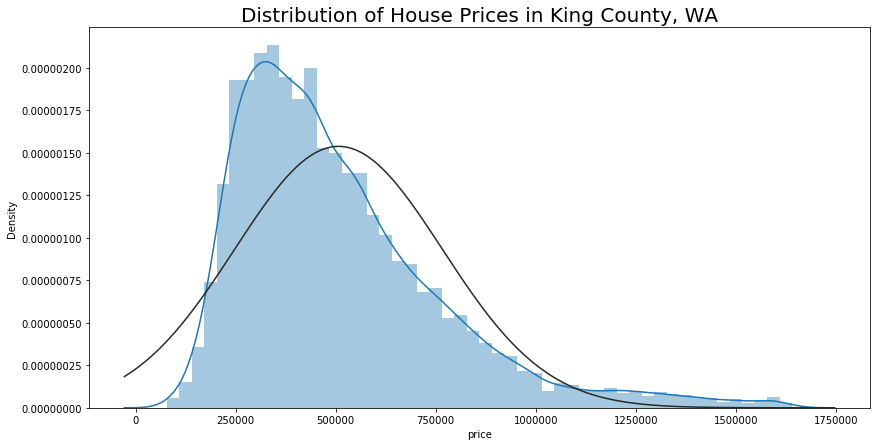

In [10]:
plt.figure(figsize=(14,7))
sns.distplot(df_no_outlier['price'], fit=norm)
plt.title("Distribution of House Prices in King County, WA", fontsize=20);
print("Distribution displays a positive skew.")
print("Skewness:", df_no_outlier['price'].skew())
print("Kurtosis:", df_no_outlier['price'].kurt())

In [11]:
#applying log transformation to 'price'
df_no_outlier['price_log'] = np.log(df_no_outlier['price'])

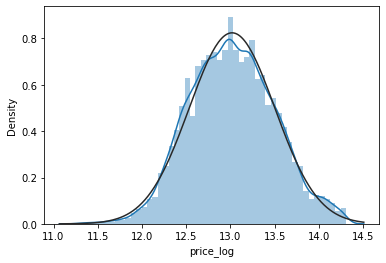

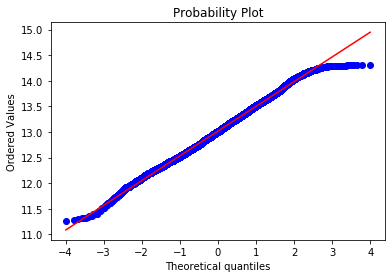

In [12]:
#visualizing the normalization of 'price'
sns.distplot(df_no_outlier['price_log'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_no_outlier['price_log'], plot=plt)

Distribution displays a positive skew.
Skewness: 1.3892777400843523
Kurtosis: 2.34772953928737


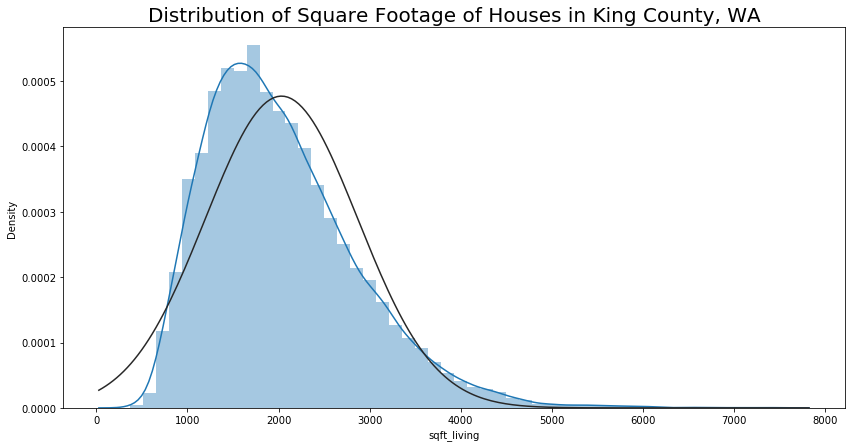

In [13]:
#histogram and normal probability plot
plt.figure(figsize=(14,7))
sns.distplot(df_no_outlier['sqft_living'], fit=norm)
plt.title("Distribution of Square Footage of Houses in King County, WA", fontsize=20);
print("Distribution displays a positive skew.")
print("Skewness:", df_no_outlier['price'].skew())
print("Kurtosis:", df_no_outlier['price'].kurt())

In [14]:
#applying log transformation to 'sqft_living'
df_no_outlier['sqft_living_log'] = np.log(df_no_outlier['sqft_living'])

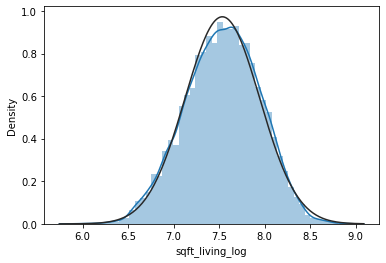

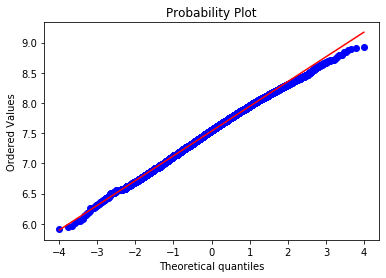

In [15]:
#visualizing the normalization of 'sqft_living'
sns.distplot(df_no_outlier['sqft_living_log'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_no_outlier['sqft_living_log'], plot=plt)

Distribution does not appear to be normally distributed.
Skewness: 1.3892777400843523
Kurtosis: 2.34772953928737


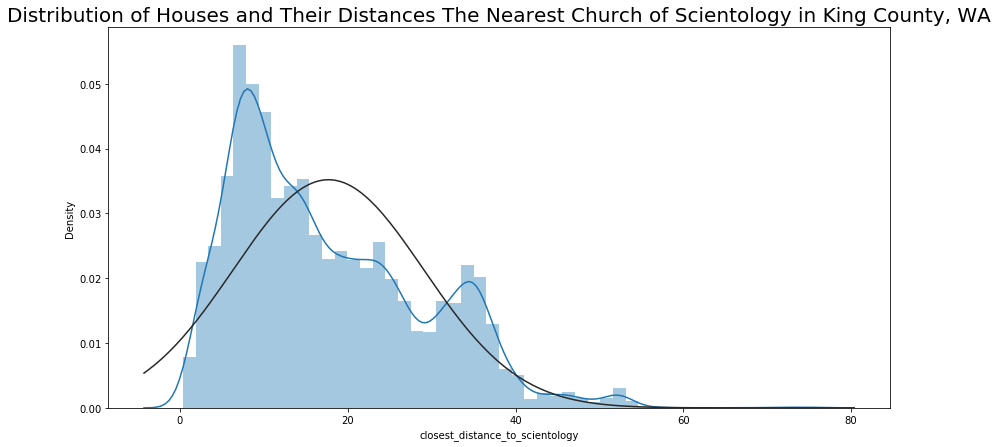

In [16]:
#histogram and normal probability plot
plt.figure(figsize=(14,7))
sns.distplot(df_no_outlier['closest_distance_to_scientology'], fit=norm)
plt.title("Distribution of Houses and Their Distances The Nearest Church of Scientology in King County, WA", fontsize=20);
print("Distribution does not appear to be normally distributed.")
print("Skewness:", df_no_outlier['price'].skew())
print("Kurtosis:", df_no_outlier['price'].kurt())

In [17]:
#data transformation
df_no_outlier['scientology_log'] = np.log(df_no_outlier['closest_distance_to_scientology'])

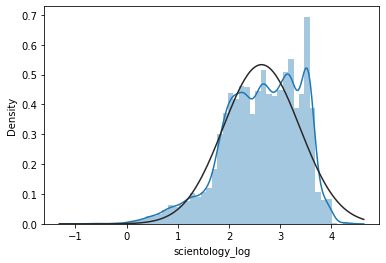

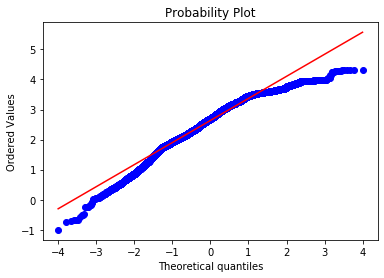

In [18]:
#transformed histogram and normal probability plot
sns.distplot(df_no_outlier['scientology_log'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_no_outlier['scientology_log'], plot=plt)

In [19]:
# Convert categorical variables (df_no_outlier[['grade', 'is_close']]) into dummy variables
df_no_outlier = pd.get_dummies(df_no_outlier)

## Identifying the model data

In [20]:
#Remove unwanted columns
drop_vars = ['price', 'sqft_living', 'closest_distance_to_scientology']
df_train_mvp = df_no_outlier.drop(columns=drop_vars)

In [21]:
df_train_mvp.head()

,grade,is_close,price_log,sqft_living_log,scientology_log
0,7,0,12.309982,7.073270,2.541998
1,7,0,13.195614,7.851661,2.379577
2,6,0,12.100712,6.646391,2.383079
3,7,0,13.311329,7.580700,2.446441
4,8,0,13.142166,7.426549,3.053153


In [22]:
# Fitting the model
outcome = 'price_log'
x_cols = ['sqft_living_log']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_train_mvp).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                 1.486e+04
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        20:15:20   Log-Likelihood:                -9062.2
No. Observations:               21191   AIC:                         1.813e+04
Df Residuals:                   21189   BIC:                         1.814e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           7.3094      0.047    155.840      0.000       7.217       7.401
sqft_living_log     0.7577      0.006    121.902      0.000       0.746       0.770
==============================================================================
Omnibus:                      244.729   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.233
Skew:                          -0.008   Prob(JB):                     1.45e-33
Kurtosis:                       2.586   Cond. No.                         141.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# Fitting the model
outcome = 'price_log'
x_cols = ['sqft_living_log', 'scientology_log']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_train_mvp).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                 1.696e+04
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        20:16:53   Log-Likelihood:                -4565.4
No. Observations:               21191   AIC:                             9137.
Df Residuals:                   21188   BIC:                             9161.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           7.4789      0.038    196.969      0.000       7.404       7.553
sqft_living_log     0.8384      0.005    164.887      0.000       0.828       0.848
scientology_log    -0.2951      0.003   -105.839      0.000      -0.301      -0.290
==============================================================================
Omnibus:                       29.648   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.492
Skew:                          -0.043   Prob(JB):                     5.34e-08
Kurtosis:                       3.175   Cond. No.                         150.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# Fitting the model
outcome = 'price_log'
x_cols = ['sqft_living_log', 'scientology_log', 'grade']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_train_mvp).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                 1.485e+04
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        20:20:41   Log-Likelihood:                -2697.6
No. Observations:               21191   AIC:                             5403.
Df Residuals:                   21187   BIC:                             5435.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.5895      0.039    220.989      0.000       8.513       8.666
sqft_living_log     0.5259      0.007     77.883      0.000       0.513       0.539
scientology_log    -0.2788      0.003   -108.628      0.000      -0.284      -0.274
grade               0.1579      0.002     63.909      0.000       0.153       0.163
==============================================================================
Omnibus:                      216.710   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              331.758
Skew:                           0.098   Prob(JB):                     9.11e-73
Kurtosis:                       3.581   Cond. No.                         232.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""